Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import phik

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier



## Загрузка и подготовка данных

In [ ]:
df = pd.read_excel('data/Данные по аналитике данных 2023.xlsx')

In [3]:
df.head()

,student_id,stream_id,stream_start_at,Диплом сдан (да / нет),Резюме сдано ( да / нет),Возврат (да/нет),Причина возврата,Возврат до старта потока,ТУ,"Урок 1го проседания в доходимости (пустая строка значит, что у студента не было просрочки, либо он вообще не сдавал дз)",Дата урока 1го проседания в доходимости,"Урок отвала на потоке (смотрим по сдаче последнего дз, у некоторых последней дз будет диплом/аттестация, то есть фактически последняя работа на курсе)",Дата урока отвала на потоке (пустая строка значит вообще не сдавал дз)
0,22530050,1451,2023-09-14,0,0,0,NaN,0,0,Excel-8. Работа с нестандартными данными,2023-10-19,Основы Python-5. Библиотека pandas. Часть 1,2024-05-27
1,20483393,758,2023-01-26,0,0,0,NaN,0,0,Урок 6. Визуализация данных и продвинутые инст...,2023-02-23,Урок 3. Когортный анализ,2023-04-06
2,21048237,851,2023-03-09,0,0,0,NaN,0,0,Урок 2. Логика: логические операторы,2023-05-04,Не сдавал ДЗ,NaT
3,22455198,1324,2023-08-31,1,1,0,NaN,0,1,Бизнес-3. Бизнес-метрики. Часть 2,2023-12-07,Дипломная работа,2024-08-15
4,20403558,846,2023-02-02,1,1,0,NaN,0,1,Урок 4. Соединение таблиц в SQL. Часть 1,2023-05-11,Дипломная работа,2023-11-16


Смотрим пропуски

In [4]:
df['student_id'].isna().sum()

np.int64(0)

## Обработка признаков

In [5]:
df.columns

Index(['student_id', 'stream_id', 'stream_start_at', 'Диплом сдан (да / нет)',
       'Резюме сдано ( да / нет)', 'Возврат (да/нет)', 'Причина возврата',
       'Возврат до старта потока', 'ТУ',
       'Урок 1го проседания в доходимости (пустая строка значит, что у студента не было просрочки, либо он вообще не сдавал дз)',
       'Дата урока 1го проседания в доходимости ',
       'Урок отвала на потоке (смотрим по сдаче последнего дз, у некоторых последней дз будет диплом/аттестация, то есть фактически последняя работа на курсе)',
       'Дата урока отвала на потоке  (пустая строка значит вообще не сдавал дз)'],
      dtype='object')

Переименую столбцы для удобства

In [6]:
columns_name = [
    'student_id',
    'stream_id',
    'date_stream_start',
    'is_diploma',
    'is_resume',
    'is_refund',
    'refund_reason',
    'is_refund_before_start',
    'tu',
    'first_dropout_lesson',
    'date_first_dropout_lesson',
    'last_dropout_lesson',
    'date_last_dropout_lesson'
]
df.columns = columns_name

In [7]:
len(df['student_id'].unique())  

2497

In [8]:
df[['student_id', 'is_refund']].to_csv('labels.csv', index=False)

Даты преобразуем в признаки "дней до первого отвала" и "дней до последнего урока"

In [9]:
df['days_to_first_dropout'] = (df['date_first_dropout_lesson'] - df['date_stream_start']).dt.days
df['days_to_last_dropout'] = (df['date_last_dropout_lesson'] - df['date_stream_start']).dt.days

In [10]:
df.drop(columns=['date_stream_start', 'date_first_dropout_lesson', 'date_last_dropout_lesson'], inplace=True)

Поработаем с причинами возврата. Пустые заполним как неизвестно.

In [11]:
len(df['refund_reason'].unique())

32

In [12]:
df['refund_reason'] = df['refund_reason'].fillna('unknown')


In [13]:
df['refund_reason'].value_counts(normalize=True)

refund_reason
unknown                                                                 0.849105
Отсутствие планирования времени                                         0.021556
Незапланированные жизненные обстоятельства помешали учебе               0.021556
Потеря интереса к профессии/обучению                                    0.016807
Понадобились деньги на другие важные расходы (доход остался прежним)    0.010596
Недооценка сложности курса до покупки                                   0.010230
Не было понимания сути профессии до покупки                             0.009865
Нет мотивации обучаться                                                 0.008769
Нет времени                                                             0.008403
Форс-мажор                                                              0.006577
Финансовые сложности                                                    0.005115
Сложный курс                                                            0.004750
Качество прода

Попробуем агрегировать в осмысленные группы:

In [14]:
reason_map = {
    'Нет времени': 'personal_issues',
    'Отсутствие планирования времени': 'personal_issues',
    'Форс-мажор': 'personal_issues',
    'Незапланированные жизненные обстоятельства помешали учебе': 'personal_issues',
    'Потеря интереса к профессии/обучению': 'personal_issues',
    'Нет мотивации обучаться': 'personal_issues',
    'Личная причина': 'personal_issues',

    'Финансовые сложности': 'financial_issues',
    'Понадобились деньги на другие важные расходы (доход остался прежним)': 'financial_issues',

    'Не было понимания сути профессии до покупки': 'wrong_expectation',
    'Недооценка сложности курса до покупки': 'wrong_expectation',
    'Сложный курс': 'wrong_expectation',
    'Не подходит онлайн': 'wrong_expectation',
    'Отзывы': 'wrong_expectation',
    'Не понравился контент': 'wrong_expectation',

    'Качество контента': 'service_quality',
    'Качество продажи': 'service_quality',
    'Не получил достаточной помощи от кураторов, наставников': 'service_quality',
    'Ошибки и недоразумения со стороны компании': 'service_quality',
    'Недозвонились, закрыли сделку': 'service_quality',

    'Выбрал ту же профессию у конкурентов': 'went_to_competitors',
    'Ушел(а) к конкурентам': 'went_to_competitors',

    'Тестовая оплата': 'technical_issues', 
    'Курс отменен': 'technical_issues',
    'Закрытие нашего курса/профессии': 'technical_issues',
    'Нецелевая заявка': 'technical_issues',
    'Клиент не ЛПР': 'technical_issues',

    'Другое': 'other',
    'Другое (напиши в примечании)': 'other',
    'Отказался называть причину': 'other',
    'К отказался назвать причину': 'other',
    'unknown': 'other',
}

df['refund_reason'] = df['refund_reason'].map(reason_map)



In [15]:
df['refund_reason'].value_counts(normalize=True)

refund_reason
other                  0.854585
personal_issues        0.084034
wrong_expectation      0.027037
financial_issues       0.015711
service_quality        0.008403
technical_issues       0.005115
went_to_competitors    0.005115
Name: proportion, dtype: float64

Попробуем агрегировать также уроки в группы:

In [16]:
print((df['first_dropout_lesson'].value_counts()).to_string())

first_dropout_lesson
Excel-3. Агрегация данных в Excel                                 234
Техническое задание Excel 1                                       165
Excel-1. Основы работы в Excel                                    131
Курсовая работа Excel                                             110
Урок 4. Основы юнит-экономики                                     110
Задание после вводного урока                                      109
Урок 1. Основы работы в Excel                                     101
Тестовое задание. Excel                                            81
Excel-2. Обработка данных в Excel                                  79
Урок 3. Агрегация данных                                           69
Урок 2. Обработка данных                                           61
Excel-7. Основы юнит-экономики                                     61
Урок 2. Бизнес-метрики                                             61
Excel-5. Когортный анализ 1                                        54

In [17]:
print((df['last_dropout_lesson'].value_counts()).to_string())

last_dropout_lesson
Дипломная работа                                                  770
Не сдавал ДЗ                                                      339
Курсовая работа Excel                                             108
Урок 7. Контроль длительности A/B теста                            52
Курсовая работа SQL                                                47
Excel-1. Основы работы в Excel                                     46
Excel-2. Обработка данных в Excel                                  40
Урок 4. Параметрические гипотезы                                   40
Урок 3. Агрегация данных                                           35
Excel-9. Визуализация данных и продвинутые инструменты дизайна     32
Урок 2. Обработка данных                                           31
A/B Тесты-5. Продвинутые A/B-тесты                                 31
Excel-5. Когортный анализ 1                                        30
Excel-4. Базовая экономика                                         29


In [18]:
def group_lessons(lesson_series: pd.Series) -> pd.Series:
    def map_topic(lesson) -> str:
        if pd.isna(lesson):
            return "Other"
        lesson = str(lesson).lower()
        if any(x in lesson for x in ["вводный", "в добрый путь", "после вводного"]):
            return "Intro"
        elif any(x in lesson for x in ["задание", "тестовое", "домаш", "резюме"]):
            return "Homework/Test"
        elif any(x in lesson for x in ["excel", "таблиц", "google sheets"]):
            return "Excel"
        elif "sql" in lesson or "python" in lesson:
            return "SQL/Python"
        elif any(x in lesson for x in ["a/b", "аб тест", "распределен", "гипотез", "статистик", "вероят"]):
            return "Analytics"
        elif any(x in lesson for x in ["бизнес", "логик", "prioritiz", "приоритизац", "юнит"]):
            return "Business/Logic"
        elif "курсовая" in lesson or "дипломная" in lesson:
            return "Projects"
        else:
            return "Other"
    return lesson_series.apply(map_topic)


df['first_dropout_lesson'] = group_lessons(df['first_dropout_lesson'])
df['last_dropout_lesson'] = group_lessons(df['last_dropout_lesson'])

In [19]:
df

,student_id,stream_id,is_diploma,is_resume,is_refund,refund_reason,is_refund_before_start,tu,first_dropout_lesson,last_dropout_lesson,days_to_first_dropout,days_to_last_dropout
0,22530050,1451,0,0,0,other,0,0,Excel,SQL/Python,35.0,256.0
1,20483393,758,0,0,0,other,0,0,Other,Other,28.0,70.0
2,21048237,851,0,0,0,other,0,0,Business/Logic,Other,56.0,NaN
3,22455198,1324,1,1,0,other,0,1,Business/Logic,Projects,98.0,350.0
4,20403558,846,1,1,0,other,0,1,Excel,Projects,98.0,287.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2732,23956182,1388,0,0,0,other,0,0,Excel,Business/Logic,39.0,81.0
2733,5642321,1028,0,0,0,other,0,0,Intro,Other,7.0,14.0
2734,22586753,1451,0,0,1,personal_issues,0,0,Excel,Other,11.0,NaN
2735,5970072,1491,0,0,1,personal_issues,1,0,Other,Other,NaN,NaN


## EDA

In [20]:
df.describe()

,student_id,stream_id,is_diploma,is_resume,is_refund,is_refund_before_start,tu,days_to_first_dropout,days_to_last_dropout
count,2.737000e+03,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2501.000000,2240.000000
mean,1.952462e+07,1173.464012,0.393497,0.251005,0.156010,0.060650,0.317866,56.281887,183.343304
std,5.855771e+06,281.088595,0.488615,0.433670,0.362931,0.238731,0.465732,59.545164,121.219030
min,9.431000e+03,757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,7.000000
25%,2.017538e+07,1011.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,67.000000
50%,2.186532e+07,1038.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.000000,182.000000
75%,2.251928e+07,1387.000000,1.000000,1.000000,0.000000,0.000000,1.000000,70.000000,294.000000
max,2.679843e+07,1692.000000,1.000000,1.000000,1.000000,1.000000,1.000000,322.000000,351.000000


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2737 entries, 0 to 2736
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   student_id              2737 non-null   int64  
 1   stream_id               2737 non-null   int64  
 2   is_diploma              2737 non-null   int64  
 3   is_resume               2737 non-null   int64  
 4   is_refund               2737 non-null   int64  
 5   refund_reason           2737 non-null   object 
 6   is_refund_before_start  2737 non-null   int64  
 7   tu                      2737 non-null   int64  
 8   first_dropout_lesson    2737 non-null   object 
 9   last_dropout_lesson     2737 non-null   object 
 10  days_to_first_dropout   2501 non-null   float64
 11  days_to_last_dropout    2240 non-null   float64
dtypes: float64(2), int64(7), object(3)
memory usage: 256.7+ KB


Заполним пропуски:

In [22]:
# 0 значит, что у студента не было просрочки, либо он вообще не сдавал дз
df['days_to_first_dropout'].fillna(0, inplace=True)

# -1 значит вообще не сдавал дз
df['days_to_last_dropout'].fillna(-1, inplace=True)

C:\Users\79504\AppData\Local\Temp\ipykernel_15688\4122690642.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['days_to_first_dropout'].fillna(0, inplace=True)
C:\Users\79504\AppData\Local\Temp\ipykernel_15688\4122690642.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

Построим pairplot численных признаков

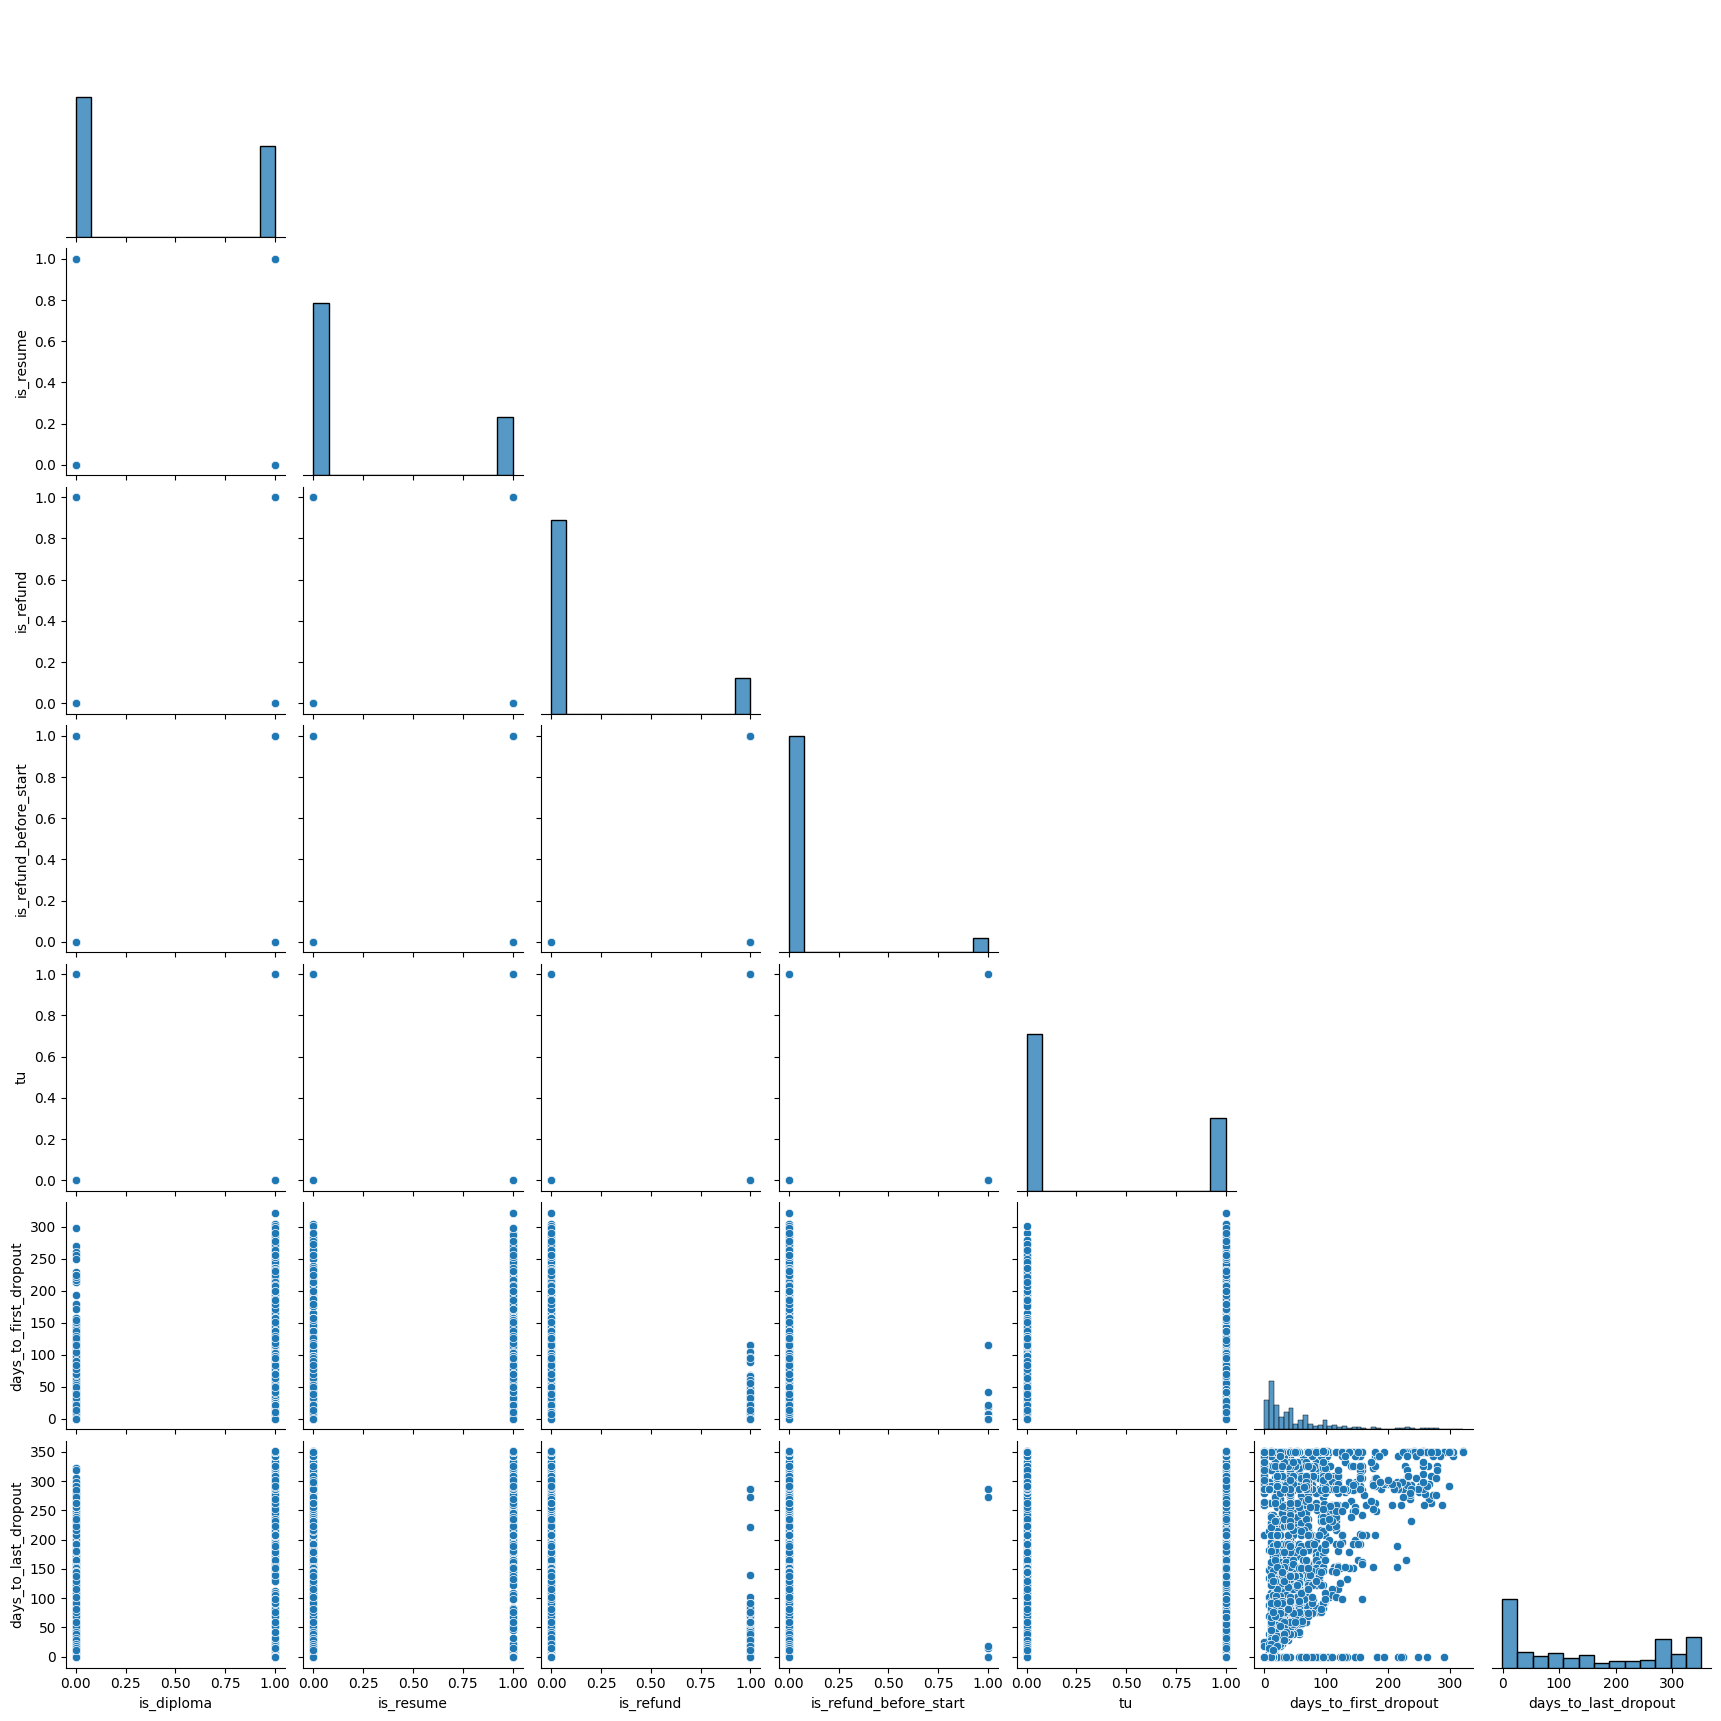

In [23]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()[2:]
sns.pairplot(df[num_cols], corner=True)

Построим корреляционную матрицу.

In [24]:
k = df[num_cols].phik_matrix(interval_cols=num_cols)

<Axes: >

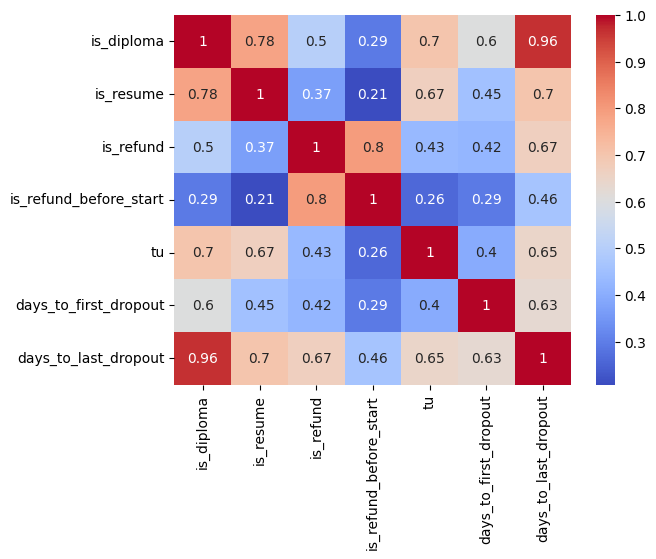

In [25]:
sns.heatmap(k, annot=True, cmap='coolwarm')

Логично, что почти полная корреляция между количеством дней до последнего урока и сдачей диплома, также есть высокая корреляция между сдачей резюме и этими признаками, нужно будет использовать регуляризацию для борьбы с мультиколлинеарностью или убрать один из признаков. На целевой признак высокого влияния отдельных факторов не наблюдается.

Посмотрим на категориальные признаки

In [26]:
cat_features = df.drop(columns=['student_id', 'stream_id', 'days_to_first_dropout', 'is_refund', 'is_refund_before_start', 'days_to_last_dropout']).columns.tolist()

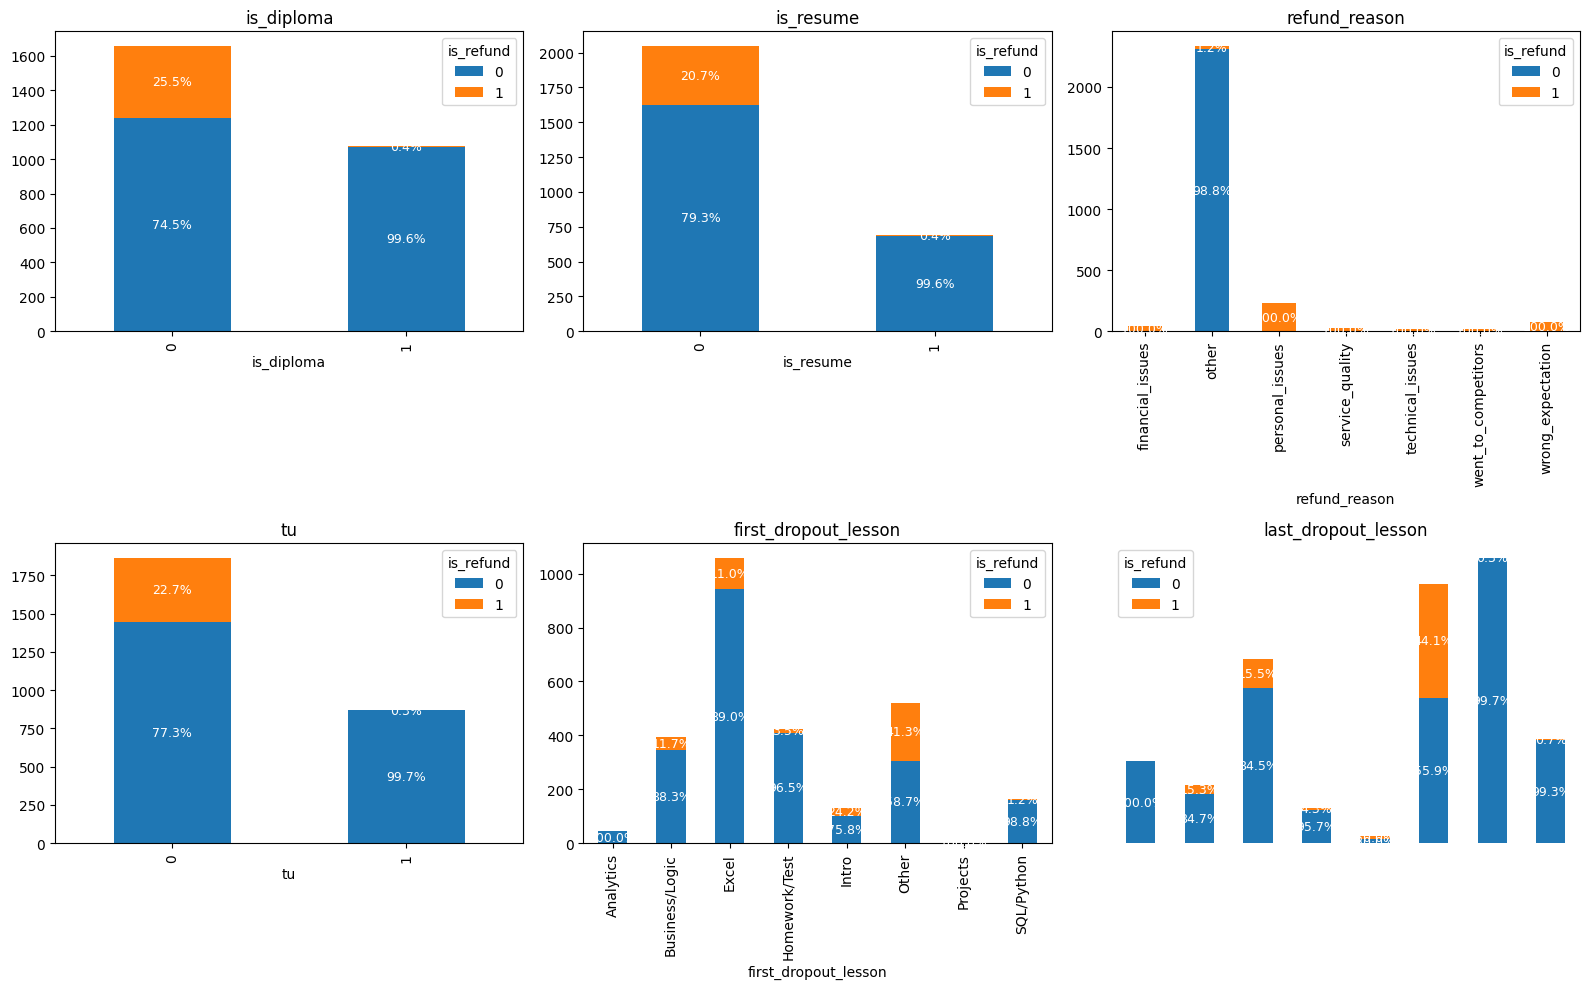

In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(16, 10)) 
axes = axes.flatten()

for i, feature in enumerate(cat_features):
    counts = df.groupby([feature, 'is_refund']).size().unstack(fill_value=0)
    total = counts.sum(axis=1)
    ax = axes[i]
    counts.plot(kind='bar', stacked=True, ax=ax)

    # Добавление процентов на каждый сегмент
    for idx, (cat_value, row) in enumerate(counts.iterrows()):
        cum_height = 0
        for refund_value in counts.columns:
            val = row[refund_value]
            percent = val / total[cat_value] * 100
            if val > 0:
                ax.text(
                    idx, cum_height + val / 2,
                    f"{percent:.1f}%",
                    ha='center', va='center', fontsize=9, color='white'
                )
            cum_height += val

    ax.set_title(feature)

# Отключаем лишнюю ось
axes[-1].axis('off')

plt.tight_layout()
plt.show()


Наличие диплома и резюме практически гарантирует удержание студента. Если с дипломом всё очевидно, то на резюме стоит обратить внимание и возможно сделать акцент на его составление и карьерную программу значит
ельно раньше, чем к концу обучения, чтобы студент был более замотивирован к выходу на рынок труда.

Видим высокую долю потеряных студентов, которые отвалились на вводных урока и технических по экселю, финальный отвал также на экселе, нужно особое внимание уделить этим занятиям.

Самые частые причины ухода: личные обстоятельства, неправильные ожидания и финансовые трудности

## Подготовка признаков для модели

Кодируем категориальные признаки one-hot-encoding

In [28]:
features = df.drop(columns=['stream_id', 'is_refund_before_start', 'refund_reason', 'days_to_last_dropout'])
features

,student_id,is_diploma,is_resume,is_refund,tu,first_dropout_lesson,last_dropout_lesson,days_to_first_dropout
0,22530050,0,0,0,0,Excel,SQL/Python,35.0
1,20483393,0,0,0,0,Other,Other,28.0
2,21048237,0,0,0,0,Business/Logic,Other,56.0
3,22455198,1,1,0,1,Business/Logic,Projects,98.0
4,20403558,1,1,0,1,Excel,Projects,98.0
...,...,...,...,...,...,...,...,...
2732,23956182,0,0,0,0,Excel,Business/Logic,39.0
2733,5642321,0,0,0,0,Intro,Other,7.0
2734,22586753,0,0,1,0,Excel,Other,11.0
2735,5970072,0,0,1,0,Other,Other,0.0


In [29]:
features = pd.get_dummies(features, columns=['first_dropout_lesson', 'last_dropout_lesson'], drop_first=True)

In [30]:
features.to_csv('features.csv', index=False)

In [31]:
features.drop(columns=['student_id'], inplace=True)

Делим на тренировочную и тестовую выборку

In [32]:
X = features.drop(columns='is_refund')
y = features['is_refund']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (2189, 18) (2189,)
Test: (548, 18) (548,)


Посмотрим на баланс классов

In [33]:
y.value_counts()

is_refund
0    2310
1     427
Name: count, dtype: int64

Используем smote для синтетического обогащения выборки для борьбы с дисбалансом

In [34]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [35]:
print(f'Размерность тренировочной выборки после сэмплирования: {X_train.shape}')
print(f'Баланс классов после сэмплирования:\n{y_train.value_counts()}')

Размерность тренировочной выборки после сэмплирования: (3704, 18)
Баланс классов после сэмплирования:
is_refund
0    1852
1    1852
Name: count, dtype: int64


Стандартизуем данные

In [38]:
scaler = StandardScaler()
X_train[['days_to_first_dropout']] = scaler.fit_transform(X_train[['days_to_first_dropout']])
X_test[['days_to_first_dropout']] = scaler.transform(X_test[['days_to_first_dropout']])

### Модель 1, логистическая регрессия

In [39]:
logistic_regression = LogisticRegression(C=1)
logistic_regression.fit(X_train, y_train)
y_pred_train_lr = logistic_regression.predict(X_train)
y_pred_test_lr = logistic_regression.predict(X_test)

In [40]:
from sklearn import metrics

In [41]:
print(f'Метрики train\n{metrics.classification_report(y_train, y_pred_train_lr)}')
print(f'Метрики test\n{metrics.classification_report(y_test, y_pred_test_lr)}')


Метрики train
              precision    recall  f1-score   support

           0       0.89      0.84      0.87      1852
           1       0.85      0.90      0.88      1852

    accuracy                           0.87      3704
   macro avg       0.87      0.87      0.87      3704
weighted avg       0.87      0.87      0.87      3704

Метрики test
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       458
           1       0.51      0.76      0.61        90

    accuracy                           0.84       548
   macro avg       0.73      0.81      0.76       548
weighted avg       0.88      0.84      0.85       548



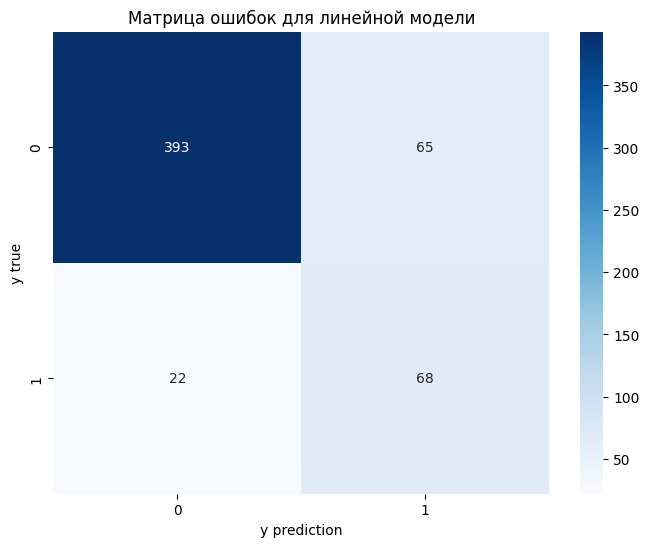

In [42]:
confusion_matrix1 = metrics.confusion_matrix(y_test, y_pred_test_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix1, annot=True, fmt='', cmap='Blues')
plt.title('Матрица ошибок для линейной модели')
plt.xlabel('y prediction')
plt.ylabel('y true')
plt.show()

### Модель 2 автоподбор гиперпараметров

In [43]:
pipeline = Pipeline([
    ('classifier', LogisticRegression())
])

param_grid = [
    {
        'classifier__solver': ['liblinear'],  
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__max_iter': [10, 50, 100, 200],
    },
    {
        'classifier__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'], 
        'classifier__penalty': ['l2'],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__max_iter': [10, 50, 100, 200],
        'classifier__tol': [1e-4, 1e-5, 1e-6],
        'classifier__fit_intercept': [True, False],
    },
    {
        'classifier__solver': ['saga'],  # saga поддерживает l1, l2 и elasticnet
        'classifier__penalty': ['elasticnet'],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__l1_ratio': [0.1, 0.5, 0.9],  # Для elasticnet нужно указать l1_ratio
        'classifier__max_iter': [10, 50, 100],
    }
]


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train) 


c:\Program Files\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Program Files\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Program Files\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Program Files\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Program Files\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Program Files\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             param_grid=[{'classifier__C': [0.1, 1, 10, 100],
                          'classifier__max_iter': [10, 50, 100, 200],
                          'classifier__penalty': ['l1', 'l2'],
                          'classifier__solver': ['liblinear']},
                         {'classifier__C': [0.1, 1, 10, 100],
                          'classifier__fit_intercept': [True, False],
                          'classifier__max_iter': [10, 50, 100, 200],
                          'classifier__penalty': ['l2'],
                          'classifier__solver': ['lbfgs', 'newton-cg', 'sag',
                                                 'saga'],
                          'classifier__tol': [0.0001, 1e-05, 1e-06]},
                         {'classifier__C': [0.1, 1, 10, 100],
                          'classifier__l1_ratio': [0.1, 0.5, 0.9],
                          'classifier__max_iter': [10, 50, 100],
                          'classifier__penalty': ['elasticnet'],
                          'classifier__solver': ['saga']}],
             scoring='f1')

In [44]:
best_model_lr = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Лучшая метрика f1 на обучающем наборе данных:", grid_search.best_score_) 


Best Parameters: {'classifier__C': 100, 'classifier__max_iter': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Лучшая метрика f1 на обучающем наборе данных: 0.8731431738228311


In [45]:
y_pred_train_gs = best_model_lr.predict(X_train)
y_pred_test_gs = best_model_lr.predict(X_test)

In [46]:
print(f'Метрики train\n{metrics.classification_report(y_train, y_pred_train_gs)}')
print(f'Метрики test\n{metrics.classification_report(y_test, y_pred_test_gs)}')


Метрики train
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      1852
           1       0.86      0.90      0.88      1852

    accuracy                           0.88      3704
   macro avg       0.88      0.88      0.87      3704
weighted avg       0.88      0.88      0.87      3704

Метрики test
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       458
           1       0.52      0.77      0.62        90

    accuracy                           0.85       548
   macro avg       0.74      0.81      0.76       548
weighted avg       0.88      0.85      0.86       548



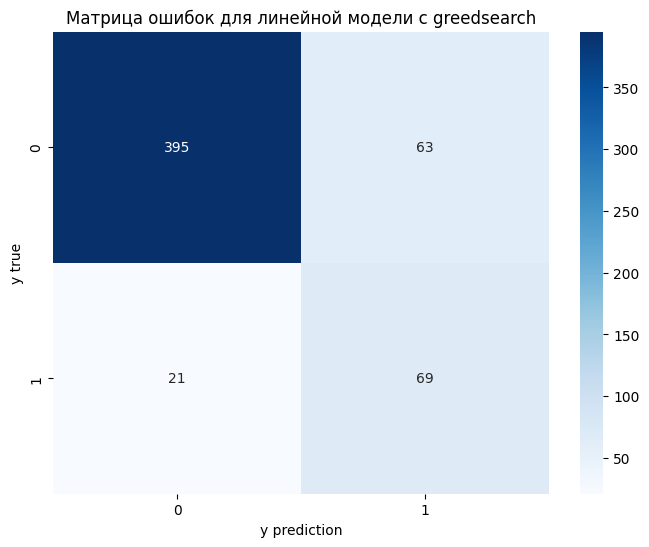

In [47]:
confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred_test_gs)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix2, annot=True, fmt='', cmap='Blues')
plt.title('Матрица ошибок для линейной модели c greedsearch')
plt.xlabel('y prediction')
plt.ylabel('y true')
plt.show()

Метрики аналогичны обычной логистической регрессии

### Модель 3 XGBoost

In [48]:
param_grid = {
    'n_estimators': [10, 25, 50],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [49]:
best_model_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Лучшая метрика f1 на обучающем наборе данных:", grid_search.best_score_) 


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Лучшая метрика f1 на обучающем наборе данных: 0.8529153206527711


In [50]:
y_pred_train_xgb = best_model_xgb.predict(X_train)
y_pred_test_xgb = best_model_xgb.predict(X_test)
print(f'Метрики train\n{metrics.classification_report(y_train, y_pred_train_xgb)}')
print(f'Метрики test\n{metrics.classification_report(y_test, y_pred_test_xgb)}')


Метрики train
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1852
           1       0.87      0.85      0.86      1852

    accuracy                           0.86      3704
   macro avg       0.86      0.86      0.86      3704
weighted avg       0.86      0.86      0.86      3704

Метрики test
              precision    recall  f1-score   support

           0       0.94      0.87      0.91       458
           1       0.53      0.73      0.62        90

    accuracy                           0.85       548
   macro avg       0.74      0.80      0.76       548
weighted avg       0.88      0.85      0.86       548



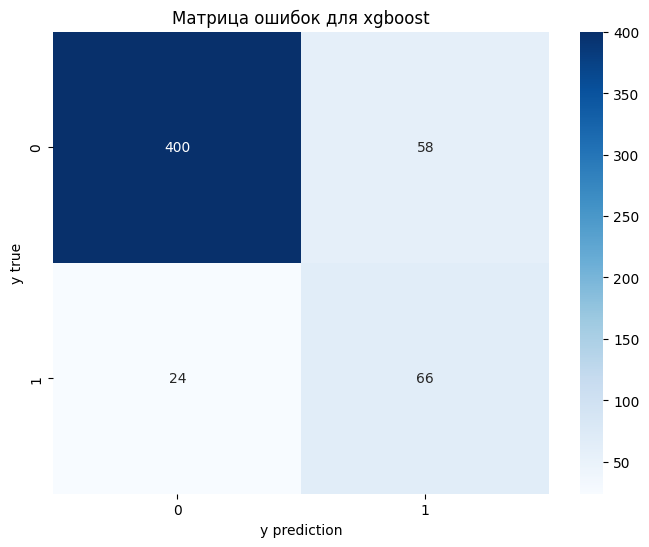

In [51]:
confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred_test_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix3, annot=True, fmt='', cmap='Blues')
plt.title('Матрица ошибок для xgboost')
plt.xlabel('y prediction')
plt.ylabel('y true')
plt.show()

### Модель 4 RandomForest

In [52]:
param_grid = {
    'n_estimators': [10, 25, 50],  
    'max_depth': [5, 10, 20, 30], 
    'max_features': ['sqrt', 'log2'], 
    'bootstrap': [True, False],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1')

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")



Best parameters: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}


In [53]:
best_model_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Лучшая метрика f1 на обучающем наборе данных:", grid_search.best_score_) 


Best Parameters: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}
Лучшая метрика f1 на обучающем наборе данных: 0.8980629607528133


In [54]:
y_pred_train_rf = best_model_rf.predict(X_train)
y_pred_test_rf = best_model_rf.predict(X_test)
print(f'Метрики train\n{metrics.classification_report(y_train, y_pred_train_rf)}')
print(f'Метрики test\n{metrics.classification_report(y_test, y_pred_test_rf)}')


Метрики train
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1852
           1       0.88      0.94      0.91      1852

    accuracy                           0.91      3704
   macro avg       0.91      0.91      0.91      3704
weighted avg       0.91      0.91      0.91      3704

Метрики test
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       458
           1       0.51      0.74      0.60        90

    accuracy                           0.84       548
   macro avg       0.73      0.80      0.75       548
weighted avg       0.87      0.84      0.85       548



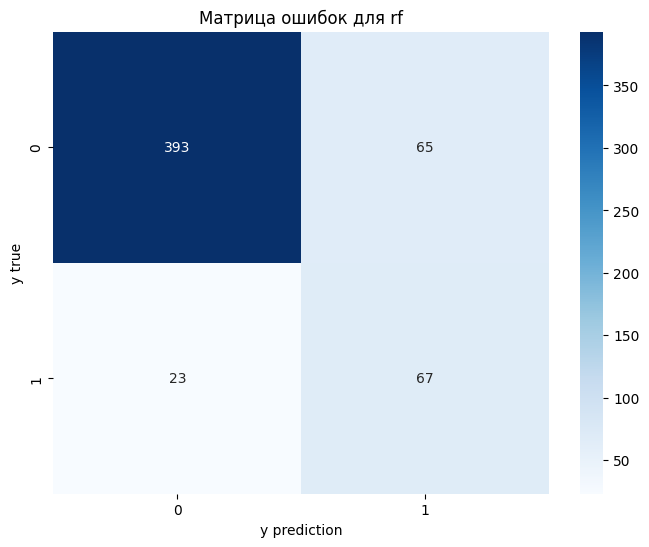

In [55]:
confusion_matrix4 = metrics.confusion_matrix(y_test, y_pred_test_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix4, annot=True, fmt='', cmap='Blues')
plt.title('Матрица ошибок для rf')
plt.xlabel('y prediction')
plt.ylabel('y true')
plt.show()

## Результаты

0.84        0.73      0.81      0.76
0.86        0.75      0.82      0.77
0.85        0.74      0.80      0.76
0.84        0.73      0.80      0.75

In [60]:
results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1'])
lr_model = {'model': 'log reg', 'accuracy': 0.84, 'precision': 0.73, 'recall': 0.81, 'f1': 0.76}
results.loc[len(results)] = lr_model
gs_model = {'model': 'log reg (l2 penalty)', 'accuracy': 0.85, 'precision': 0.74, 'recall': 0.81, 'f1': 0.76}
results.loc[len(results)] = gs_model
xgb_model = {'model': 'xgboost', 'accuracy': 0.85, 'precision': 0.74, 'recall': 0.80, 'f1': 0.76}
results.loc[len(results)] = xgb_model
rf_model = {'model': 'random forest', 'accuracy': 0.84, 'precision': 0.73, 'recall': 0.80, 'f1': 0.75}
results.loc[len(results)] = rf_model



In [61]:
print('Метрики на тестовом датасете')
results

Метрики на тестовом датасете


,model,accuracy,precision,recall,f1
0,log reg,0.84,0.73,0.81,0.76
1,log reg (l2 penalty),0.85,0.74,0.81,0.76
2,xgboost,0.85,0.74,0.80,0.76
3,random forest,0.84,0.73,0.80,0.75
